In [7]:
# https://github.com/jin-s13/COCO-WholeBody
# https://cocodataset.org/#download
# https://cocodataset.org/#keypoints-2017

In [37]:
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [58]:
# Read ids of train and validataion data
train_path = "data/coco_wholebody_train_v1.0.json"
test_path = "data/coco_wholebody_val_v1.0.json"

f = open(train_path)
train_dict = json.load(f)

f = open(test_path)
test_dict = json.load(f)

print(list(train_dict))

['info', 'licenses', 'images', 'annotations', 'categories']


In [79]:
# Get the ids of the images in the train and test (dont use all 100k)
N_train = 1000
N_test = 500

train_ids = [im['id'] for im in train_dict["images"][:N_train]]
train_paths = [im['file_name'] for im in train_dict["images"][:N_train]]

test_ids = [im['id'] for im in test_dict["images"][:N_test]]
test_paths = [im['file_name'] for im in test_dict["images"][:N_test]]

In [86]:
# Read the images (X)
X_train = [np.asarray(Image.open("data/train2017/" + name)) for name in train_paths]
X_test = [np.asarray(Image.open("data/val2017/" + name)) for name in test_paths]

X_train = np.array(X_train, dtype="object")
X_test = np.array(X_test, dtype="object")


# Read the annotations (y)
y_train = [im['face_box'] for im in train_dict['annotations']]
y_test = [im['face_box'] for im in test_dict['annotations']]

y_train = np.array(y_train, dtype="object")
y_test = np.array(y_test, dtype="object")

In [87]:
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

X_train: (1000,)
X_test: (500,)
y_train: (262465, 4)
y_test: (11004, 4)


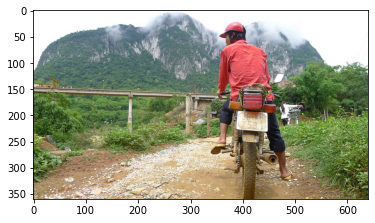

In [63]:
plt.imshow(train[0])

In [73]:
annotations = [(x['id'], x['face_box']) for x in train_dict['annotations']]

In [74]:
annotations[:10]

[(183020, [0.0, 0.0, 0.0, 0.0]),
 (183030, [0.0, 0.0, 0.0, 0.0]),
 (183050, [0.0, 0.0, 0.0, 0.0]),
 (183057, [0.0, 0.0, 0.0, 0.0]),
 (183062, [0.0, 0.0, 0.0, 0.0]),
 (183092, [0.0, 0.0, 0.0, 0.0]),
 (183103, [0.0, 0.0, 0.0, 0.0]),
 (183141, [0.0, 0.0, 0.0, 0.0]),
 (183194, [0.0, 0.0, 0.0, 0.0]),
 (183218, [0.0, 0.0, 0.0, 0.0])]